## Enron Email Classification using Word Embeddings and LSTM

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b/glove.6B.200d.txt
/kaggle/input/glove6b/glove.6B.50d.txt
/kaggle/input/glove6b/glove.6B.300d.txt
/kaggle/input/glove6b/glove.6B.100d.txt
/kaggle/input/gensim-embeddings-dataset/crawl-300d-2M.gensim
/kaggle/input/gensim-embeddings-dataset/GoogleNews-vectors-negative300.gensim
/kaggle/input/gensim-embeddings-dataset/paragram_300_sl999.gensim.vectors.npy
/kaggle/input/gensim-embeddings-dataset/glove.twitter.27B.200d.gensim
/kaggle/input/gensim-embeddings-dataset/numberbatch-en.gensim.vectors.npy
/kaggle/input/gensim-embeddings-dataset/glove.840B.300d.gensim
/kaggle/input/gensim-embeddings-dataset/crawl-300d-2M.gensim.vectors.npy
/kaggle/input/gensim-embeddings-dataset/glove.twitter.27B.200d.gensim.vectors.npy
/kaggle/input/gensim-embeddings-dataset/numberbatch-en.gensim
/kaggle/input/gensim-embeddings-dataset/glove.840B.300d.gensim.vectors.npy
/kaggle/input/gensim-embeddings-dataset/paragram_300_sl999.gensim
/kaggle/input/gensim-embeddings-dataset/GoogleNews-vectors-

## 1. Import necessary libraries

In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, LSTM, Embedding, Input, Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers import Dropout
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping

from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

## 2. Load Pre-trained word embeddings

#### 2.1 Google's Word Embedding

In [3]:
# load google's pre-trained word2vec embeddings
filename = "/kaggle/input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin"

start = time.time()
google_embeddings = KeyedVectors.load_word2vec_format(filename, binary=True)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  61.3519811630249


#### 2.2 Stanford's Word Embedding

In [4]:
# load Stanford's pre-trained GloVe embeddings
glove_file = "/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.300d.txt"
glove_word2vec_file = "glove.6B.300d.txt.word2vec"

glove2word2vec(glove_file, glove_word2vec_file)

(400000, 300)

In [5]:
# glove embeddings
start = time.time()

glove_embeddings = KeyedVectors.load_word2vec_format(glove_word2vec_file, binary=False)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  188.55974650382996


## 3. Load Data

In [6]:
# load data
df = pd.read_csv("/kaggle/input/enron-email-classification-using-machine-learning/preprocessed.csv")

# view first 5 rows of the dataframe 'df'
df.head()

,X-Folder,text
0,california,caiso notice summer 2001 generation rfb market...
1,california,ca iso cal px information related 2000 market ...
2,california,caiso notification update inter sc trades adju...
3,california,update mif meeting presentations iso website u...
4,california,mif presentations presentations market issues ...


In [87]:
no_words_arr = []
for text in df['text']:
    no_words = len(text.split())
    no_words_arr.append(no_words)
    
df['no_words'] = no_words_arr

In [93]:
df[df['no_words'] < 100].shape

(8178, 3)

## 4. Prepare Data

In [7]:
# shape of the data
df.shape

(13586, 2)

#### Encode class labels

In [8]:
def label_encoder(df):
    class_le = LabelEncoder()
    # apply label encoder on the 'X-Folder' column
    y = class_le.fit_transform(df['X-Folder'])
    return y

In [9]:
y = label_encoder(df)
corpus = df['text']

In [10]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(corpus, y, test_size=0.1, random_state=0)

**Find total number of words in our corpus**

In [11]:
all_words = []

for sent in corpus:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

In [12]:
# retrieve all unique words from all_words
unique_words = set(all_words)
print("Unique words: ",len(unique_words))

Unique words:  0


In [13]:
# prepare tokenizer
t = Tokenizer()

# fit the tokenizer on the docs
t.fit_on_texts(corpus)

# integer encode the documents
train_encoded_docs = t.texts_to_sequences(X_train)
test_encoded_docs = t.texts_to_sequences(X_test)

In [94]:
# find the largest doc to make all the docs of uniform size i.e size of largest doc
word_count = lambda doc: len(word_tokenize(doc))
longest_doc = max(corpus, key=word_count)
length_longest_doc = len(word_tokenize(longest_doc))
length_longest_doc = 100

In [95]:
# to make all the docs of equal size, we will add zeros to empty indexes
train_padded_docs = pad_sequences(train_encoded_docs, length_longest_doc, padding='post')
test_padded_docs = pad_sequences(test_encoded_docs, length_longest_doc, padding='post')

In [96]:
# one-hot encode the output labels
Y_train = to_categorical(y_train, 20)
Y_test = to_categorical(y_test, 20)

## 5. Learn Own Word Embeddings

In [17]:
docs = []

for doc in corpus:
    li = list(doc.split())
    docs.append(li)

In [18]:
start = time.time()
# train the model
model = Word2Vec(docs, size=300, window=5, min_count=1, workers=4, sg=0)
# summarize the loaded model
print(model)
# save the model
model.save("email_embeddings.bin")

print("Training time (seconds): ", (time.time() - start))

Word2Vec(vocab=59654, size=300, alpha=0.025)
Training time (seconds):  46.05647277832031


In [19]:
# load own word embeddings
start = time.time()

filename = "email_embeddings.bin"

email_embeddings = Word2Vec.load(filename)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  0.3239095211029053


In [24]:
vocab_size = len(email_embeddings.wv.vocab)

## 6. Email Classification using Email Word Embeddings

In [97]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
count = 0

for word, i in t.word_index.items():
    if word in email_embeddings.wv.vocab.keys():
        embedding_vector = email_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    else:
        count += 1

In [98]:
embedding_matrix.shape

(59654, 300)

In [99]:
print("Number of words not present in email_embeddings: ", count)

Number of words not present in email_embeddings:  37


In [100]:
# define the model
email_model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=length_longest_doc, trainable=False)
email_model.add(e)
email_model.add(LSTM(100, dropout=0.4))
email_model.add(Flatten())
email_model.add(Dense(20, activation='softmax'))


# compile the model
email_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# print model summary
email_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          17896200  
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               160400    
_________________________________________________________________
flatten_6 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2020      
Total params: 18,058,620
Trainable params: 162,420
Non-trainable params: 17,896,200
_________________________________________________________________


In [101]:
start = time.time()

# train the model
email_hist = email_model.fit(train_padded_docs, Y_train, epochs=100, verbose=1, validation_split=0.1)

print("Training time (minutes): ", (round((time.time() - start)/60, 2)))

Epoch 1/100
344/344 [==============================] - 4s 10ms/step - loss: 2.6531 - accuracy: 0.1875 - val_loss: 2.3952 - val_accuracy: 0.2764
Epoch 2/100
344/344 [==============================] - 3s 10ms/step - loss: 2.3956 - accuracy: 0.2693 - val_loss: 2.2891 - val_accuracy: 0.3303
Epoch 3/100
344/344 [==============================] - 3s 9ms/step - loss: 2.1118 - accuracy: 0.3728 - val_loss: 1.9240 - val_accuracy: 0.4325
Epoch 4/100
344/344 [==============================] - 3s 9ms/step - loss: 1.7527 - accuracy: 0.4756 - val_loss: 1.5285 - val_accuracy: 0.5405
Epoch 5/100
344/344 [==============================] - 3s 9ms/step - loss: 1.5273 - accuracy: 0.5301 - val_loss: 1.3608 - val_accuracy: 0.5715
Epoch 6/100
344/344 [==============================] - 3s 9ms/step - loss: 1.3523 - accuracy: 0.5837 - val_loss: 1.2716 - val_accuracy: 0.6124
Epoch 7/100
344/344 [==============================] - 3s 8ms/step - loss: 1.2423 - accuracy: 0.6160 - val_loss: 1.1809 - val_accuracy: 0.62

Epoch 58/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2731 - accuracy: 0.9034 - val_loss: 1.0536 - val_accuracy: 0.7522
Epoch 59/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2551 - accuracy: 0.9129 - val_loss: 1.0469 - val_accuracy: 0.7465
Epoch 60/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2612 - accuracy: 0.9060 - val_loss: 1.0304 - val_accuracy: 0.7645
Epoch 61/100
344/344 [==============================] - 3s 8ms/step - loss: 0.2682 - accuracy: 0.9045 - val_loss: 1.0734 - val_accuracy: 0.7441
Epoch 62/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2584 - accuracy: 0.9106 - val_loss: 1.0527 - val_accuracy: 0.7612
Epoch 63/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2563 - accuracy: 0.9099 - val_loss: 1.0371 - val_accuracy: 0.7572
Epoch 64/100
344/344 [==============================] - 3s 8ms/step - loss: 0.2408 - accuracy: 0.9138 - val_loss: 1.0758 - val_accuracy:

In [102]:
# evaluate the model
email_train_eval = email_model.evaluate(train_padded_docs, Y_train, verbose=0)
email_test_eval = email_model.evaluate(test_padded_docs, Y_test, verbose=0)

print("Train Accuracy: {:0.3f}    Loss: {:0.3f}".format(email_train_eval[1], email_train_eval[0]))
print("Test Accuracy:  {:0.3f}    Loss: {:0.3f}".format(email_test_eval[1], email_test_eval[0]))

Train Accuracy: 0.942    Loss: 0.209
Test Accuracy:  0.717    Loss: 1.343


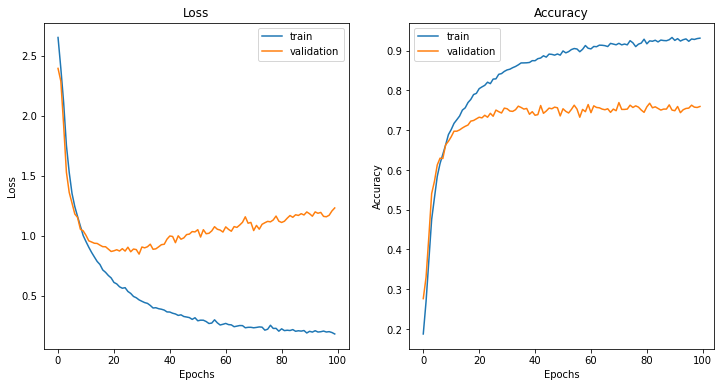

In [103]:
fig, axis = plt.subplots(1,2, figsize=(12, 6))
# plot the loss
axis[0].set_title("Loss")
axis[0].plot(email_hist.history['loss'], label='train')
axis[0].plot(email_hist.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel("Loss")

# plot the accuracy
axis[1].set_title("Accuracy")
axis[1].plot(email_hist.history['accuracy'], label='train')
axis[1].plot(email_hist.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel("Accuracy")

plt.show()

## 7. Using Word2Vec

In [104]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))

count = 0

for word, i in t.word_index.items():
    if word in google_embeddings.wv.vocab.keys():
        embedding_vector = google_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    elif word in email_embeddings.wv.vocab.keys():
        embedding_vector = email_embeddings[word]
        
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    else: 
        count += 1

In [105]:
embedding_matrix.shape

(59654, 300)

In [106]:
# define the model
w2v_model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=length_longest_doc, trainable=False)
w2v_model.add(e)
w2v_model.add(LSTM(100, dropout=0.4))
w2v_model.add(Flatten())
w2v_model.add(Dense(20, activation='softmax'))

# compile the model
w2v_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# print model summary
w2v_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          17896200  
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               160400    
_________________________________________________________________
flatten_7 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                2020      
Total params: 18,058,620
Trainable params: 162,420
Non-trainable params: 17,896,200
_________________________________________________________________


In [107]:
start = time.time()

# train the model
w2v_hist = w2v_model.fit(train_padded_docs, Y_train, epochs=100, verbose=1, validation_split=0.1)

print("Training time (minutes): ", (round((time.time() - start)/60, 2)))

Epoch 1/100
344/344 [==============================] - 4s 10ms/step - loss: 2.7578 - accuracy: 0.1557 - val_loss: 2.7490 - val_accuracy: 0.1594
Epoch 2/100
344/344 [==============================] - 3s 10ms/step - loss: 2.6083 - accuracy: 0.2023 - val_loss: 2.4226 - val_accuracy: 0.2666
Epoch 3/100
344/344 [==============================] - 3s 9ms/step - loss: 2.5767 - accuracy: 0.2216 - val_loss: 2.3867 - val_accuracy: 0.2952
Epoch 4/100
344/344 [==============================] - 3s 8ms/step - loss: 2.5438 - accuracy: 0.2325 - val_loss: 2.3258 - val_accuracy: 0.3091
Epoch 5/100
344/344 [==============================] - 3s 9ms/step - loss: 2.4751 - accuracy: 0.2585 - val_loss: 2.3640 - val_accuracy: 0.2854
Epoch 6/100
344/344 [==============================] - 3s 9ms/step - loss: 2.3618 - accuracy: 0.2910 - val_loss: 2.1981 - val_accuracy: 0.3516
Epoch 7/100
344/344 [==============================] - 3s 9ms/step - loss: 2.3543 - accuracy: 0.2844 - val_loss: 2.2070 - val_accuracy: 0.30

Epoch 58/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2578 - accuracy: 0.9103 - val_loss: 0.7549 - val_accuracy: 0.7956
Epoch 59/100
344/344 [==============================] - 3s 10ms/step - loss: 0.2573 - accuracy: 0.9089 - val_loss: 0.7924 - val_accuracy: 0.7956
Epoch 60/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2570 - accuracy: 0.9087 - val_loss: 0.8234 - val_accuracy: 0.7915
Epoch 61/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2519 - accuracy: 0.9135 - val_loss: 0.8062 - val_accuracy: 0.7907
Epoch 62/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2531 - accuracy: 0.9133 - val_loss: 0.8009 - val_accuracy: 0.7923
Epoch 63/100
344/344 [==============================] - 3s 10ms/step - loss: 0.2337 - accuracy: 0.9156 - val_loss: 0.8300 - val_accuracy: 0.7980
Epoch 64/100
344/344 [==============================] - 3s 10ms/step - loss: 0.2477 - accuracy: 0.9111 - val_loss: 0.8349 - val_accura

In [108]:
# evaluate the model
w2v_train_eval = w2v_model.evaluate(train_padded_docs, Y_train, verbose=0)
w2v_test_eval = w2v_model.evaluate(test_padded_docs, Y_test, verbose=0)

print("Train Accuracy: {:0.3f}    Loss: {:0.3f}".format(w2v_train_eval[1], w2v_train_eval[0]))
print("Test Accuracy:  {:0.3f}    Loss: {:0.3f}".format(w2v_test_eval[1], w2v_test_eval[0]))

Train Accuracy: 0.952    Loss: 0.160
Test Accuracy:  0.767    Loss: 1.127


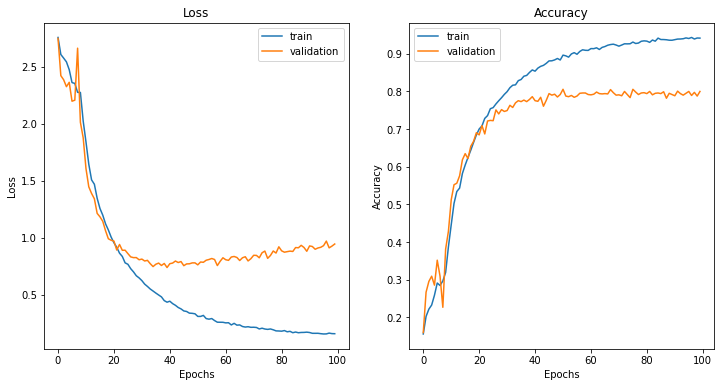

In [109]:
fig, axis = plt.subplots(1,2, figsize=(12, 6))
# plot the loss
axis[0].set_title("Loss")
axis[0].plot(w2v_hist.history['loss'], label='train')
axis[0].plot(w2v_hist.history['val_loss'], label='validation')
axis[0].legend()
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel("Loss")

# plot the accuracy
axis[1].set_title("Accuracy")
axis[1].plot(w2v_hist.history['accuracy'], label='train')
axis[1].plot(w2v_hist.history['val_accuracy'], label='validation')
axis[1].legend()
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel("Accuracy")

plt.show()

## 8. Using GloVe 

In [110]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size, 300))

count = 0

for word, i in t.word_index.items():
    if word in glove_embeddings.wv.vocab.keys():
        embedding_vector = glove_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    elif word in email_embeddings.wv.vocab.keys():
        embedding_vector = email_embeddings[word]
        
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    else: 
        count += 1

In [111]:

# define the model
glove_model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=100, trainable=False)
glove_model.add(e)
glove_model.add(LSTM(100, dropout=0.4))
glove_model.add(Flatten())
glove_model.add(Dense(20, activation='softmax'))

# compile the model
glove_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# print model summary
glove_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 300)          17896200  
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               160400    
_________________________________________________________________
flatten_8 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                2020      
Total params: 18,058,620
Trainable params: 162,420
Non-trainable params: 17,896,200
_________________________________________________________________


In [112]:
start = time.time()
# train the model
hist = glove_model.fit(train_padded_docs, Y_train, epochs=100, validation_split=0.1)

print("Training time (minutes): ",(round((time.time()-start)/60, 2)))

Epoch 1/100
344/344 [==============================] - 4s 10ms/step - loss: 2.6483 - accuracy: 0.1788 - val_loss: 2.3703 - val_accuracy: 0.2567
Epoch 2/100
344/344 [==============================] - 3s 9ms/step - loss: 2.4358 - accuracy: 0.2651 - val_loss: 2.1920 - val_accuracy: 0.3213
Epoch 3/100
344/344 [==============================] - 3s 9ms/step - loss: 2.5404 - accuracy: 0.2326 - val_loss: 2.4691 - val_accuracy: 0.2617
Epoch 4/100
344/344 [==============================] - 3s 10ms/step - loss: 2.3513 - accuracy: 0.2927 - val_loss: 2.1755 - val_accuracy: 0.3205
Epoch 5/100
344/344 [==============================] - 3s 9ms/step - loss: 2.2954 - accuracy: 0.3118 - val_loss: 2.0851 - val_accuracy: 0.3704
Epoch 6/100
344/344 [==============================] - 3s 9ms/step - loss: 2.2637 - accuracy: 0.3244 - val_loss: 2.0557 - val_accuracy: 0.3720
Epoch 7/100
344/344 [==============================] - 3s 9ms/step - loss: 2.0785 - accuracy: 0.3677 - val_loss: 1.9365 - val_accuracy: 0.39

Epoch 58/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2092 - accuracy: 0.9270 - val_loss: 0.8365 - val_accuracy: 0.7931
Epoch 59/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2059 - accuracy: 0.9270 - val_loss: 0.8687 - val_accuracy: 0.7858
Epoch 60/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2146 - accuracy: 0.9236 - val_loss: 0.8193 - val_accuracy: 0.7923
Epoch 61/100
344/344 [==============================] - 3s 9ms/step - loss: 0.2016 - accuracy: 0.9251 - val_loss: 0.8435 - val_accuracy: 0.7956
Epoch 62/100
344/344 [==============================] - 3s 9ms/step - loss: 0.1961 - accuracy: 0.9305 - val_loss: 0.8304 - val_accuracy: 0.7907
Epoch 63/100
344/344 [==============================] - 3s 9ms/step - loss: 0.1944 - accuracy: 0.9290 - val_loss: 0.7974 - val_accuracy: 0.8029
Epoch 64/100
344/344 [==============================] - 3s 9ms/step - loss: 0.1936 - accuracy: 0.9295 - val_loss: 0.8461 - val_accuracy:

In [113]:
# evaluate the model
train_accr = glove_model.evaluate(train_padded_docs, Y_train, verbose=0)
test_accr = glove_model.evaluate(test_padded_docs, Y_test, verbose=0)

print("Train Accuracy: {:0.3f}    Loss: {:0.3f}".format(train_accr[1], train_accr[0]))
print("Test Accuracy:  {:0.3f}    Loss: {:0.3f}".format(test_accr[1], test_accr[0]))

Train Accuracy: 0.955    Loss: 0.147
Test Accuracy:  0.782    Loss: 1.028


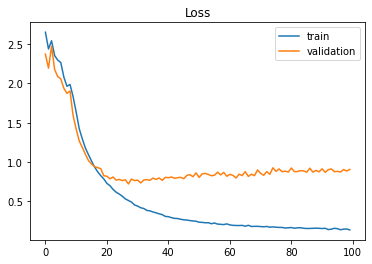

In [114]:
# plot the loss
plt.title("Loss")
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend()
plt.show()

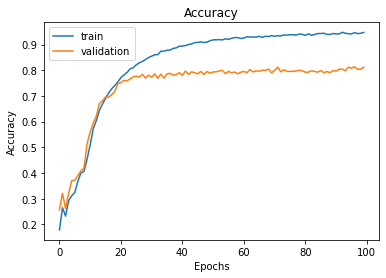

In [115]:
# plot the accuracy
plt.title("Accuracy")
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()